In [ ]:

import pandas as pd
import numpy as np
import re, math
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [ ]:


phishtank = pd.read_csv("verified_online.csv", on_bad_lines='skip')
openphish = pd.read_csv("openPhish.csv", header=None, on_bad_lines='skip')
tranco = pd.read_csv("tranco_8LKJV.csv", on_bad_lines='skip')

# Normalize column names
phishtank.rename(columns={c: c.lower() for c in phishtank.columns}, inplace=True)
tranco.rename(columns={c: c.lower() for c in tranco.columns}, inplace=True)

# Map URL columns
pt_url = [c for c in phishtank.columns if 'url' in c]
if not pt_url: raise KeyError("PhishTank: URL column not found")
phishtank = phishtank[[pt_url[0]]].rename(columns={pt_url[0]:'url'})

if openphish.shape[1] == 1:
    openphish.columns = ['url']
else:
    op_url = [c for c in openphish.columns if 'url' in str(c).lower()]
    openphish = openphish[[op_url[0]]].rename(columns={op_url[0]:'url'})

tr_url = [c for c in tranco.columns if 'url' in c or 'domain' in c]
if tr_url:
    tranco = tranco[[tr_url[-1]]].rename(columns={tr_url[-1]:'url'})
else:
    # common Tranco format: rank,domain
    if tranco.shape[1] >= 2:
        tranco = tranco.iloc[:, [1]].rename(columns={tranco.columns[1]: 'url'})
    else:
        raise KeyError("Tranco: URL/domain column not found")

# Tag & label
phishtank['source'] = 'PhishTank'; phishtank['label'] = 1 # 1 - phishing 0- benign
openphish['source'] = 'OpenPhish'; openphish['label'] = 1
tranco['source']   = 'Tranco';    tranco['label']   = 0

# Combine
raw_ds = pd.concat([phishtank, openphish, tranco], ignore_index=True)
print("Loaded:", raw_ds['source'].value_counts())
raw_ds.head()


Loaded: source
Tranco       295446
PhishTank     37600
OpenPhish       300
Name: count, dtype: int64


,url,source,label
0,https://honest-listening-508686.framer.app/,PhishTank,1
1,https://linksta.cc/@btmail-update,PhishTank,1
2,https://sncf-offres.com/check.php,PhishTank,1
3,https://sncf-offres.com/,PhishTank,1
4,https://linksta.cc/@SAdhjbd,PhishTank,1


In [ ]:
raw_ds.describe()

,label
count,333346.000000
mean,0.113696
std,0.317442
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
#counts and phishing target size
def clean_url(u: str):
    if not isinstance(u, str): return np.nan
    u = u.strip().lower()
    u = re.sub(r'^https?:\/\/', '', u)   # remove scheme
    u = re.sub(r'^www\.', '', u)         # remove www
    u = re.sub(r'#.*', '', u)            # drop fragments
    u = re.sub(r'\?.*', '', u)           # drop query
    u = re.sub(r'\/+', '/', u)           # collapse //
    if u.endswith('/'): u = u[:-1]
    return u if len(u) > 5 else np.nan

ds = raw_ds.copy()
ds['url'] = ds['url'].apply(clean_url)
before = len(ds)
ds.dropna(subset=['url'], inplace=True)
ds.drop_duplicates(subset=['url'], inplace=True)
after = len(ds)

print(f"Cleaned rows removed: {before - after}")
print(ds['source'].value_counts())
ds.head()


Cleaned rows removed: 3658
source
Tranco       294366
PhishTank     35065
OpenPhish       257
Name: count, dtype: int64


,url,source,label
0,honest-listening-508686.framer.app,PhishTank,1
1,linksta.cc/@btmail-update,PhishTank,1
2,sncf-offres.com/check.php,PhishTank,1
3,sncf-offres.com,PhishTank,1
4,linksta.cc/@sadhjbd,PhishTank,1


In [ ]:

counts = ds.groupby('source').size()
phish_n = ds.loc[ds['label']==1].shape[0]
benign_n = ds.loc[ds['label']==0].shape[0]
print("Totals  | phishing:", phish_n, " benign:", benign_n)
print("\nPer-source:\n", counts)


Totals  | phishing: 35322  benign: 294366

Per-source:
 source
OpenPhish       257
PhishTank     35065
Tranco       294366
dtype: int64


In [ ]:

#copy
full_ds = ds.copy()

# Phishing pool (PhishTank + OpenPhish)
phish_ds = ds[ds['label']==1]

# Benign pool (Tranco)
benign_ds = ds[ds['label']==0]

target_benign = len(phish_ds)  # match phishing count

def hardness_score(url):
    return (
        len(url) * 0.4
        + url.count('-') * 0.3
        + sum(ch.isdigit() for ch in url) * 0.2
        + url.count('.') * 0.1
    )

benign_ds = benign_ds.assign(_h=benign_ds['url'].apply(hardness_score))
hard_benign = benign_ds.sort_values('_h', ascending=False).head(int(target_benign*0.6))
rand_benign = benign_ds.drop(hard_benign.index).sample(
    n=target_benign - len(hard_benign), random_state=42
)
benign_bal = pd.concat([hard_benign, rand_benign]).drop(columns=['_h'])

dev_ds = pd.concat([phish_ds, benign_bal], ignore_index=True)
dev_ds = dev_ds.sample(frac=1, random_state=42).reset_index(drop=True)

print("DEV set size:", len(dev_ds))
print(dev_ds['label'].value_counts())
dev_ds.head()


DEV set size: 70644
label
0    35322
1    35322
Name: count, dtype: int64


,url,source,label
0,crosslanguage.co.jp,Tranco,0
1,nationalstocknumber.info,Tranco,0
2,q-r.to/bfk3po,PhishTank,1
3,67-72chevytrucks.com,Tranco,0
4,mpujj.org,Tranco,0


In [ ]:

def shannon_entropy(s):
    if not s: return 0.0
    probs = [s.count(c)/len(s) for c in set(s)]
    return -sum(p*math.log(p,2) for p in probs)

def extract_features(url):
    p = urlparse('http://' + url)  # ensure parsable
    domain, path = p.netloc, p.path
    return {
        'url_length': len(url),
        'domain_length': len(domain),
        'path_length': len(path),
        'count_dot': url.count('.'),
        'count_hyphen': url.count('-'),
        'count_slash': url.count('/'),
        'count_digit': sum(ch.isdigit() for ch in url),
        'count_alpha': sum(ch.isalpha() for ch in url),
        'count_special': len(re.findall(r'[@?%&=+\-_#:/]', url)),
        'has_at': int('@' in url),
        'has_ip': int(bool(re.search(r'(\d{1,3}\.){3}\d{1,3}', domain))),
        'subdomain_count': domain.count('.'),
        'tld_length': len(domain.split('.')[-1]) if '.' in domain else 0,
        'entropy': shannon_entropy(url),
        'has_login': int('login' in url),
        'has_secure': int('secure' in url),
        'has_verify': int('verify' in url),
        'has_account': int('account' in url),
        'has_pay': int('pay' in url),
        'has_update': int('update' in url),
    }

feat_dev = dev_ds['url'].apply(extract_features).apply(pd.Series)
dev = pd.concat([dev_ds[['url','source','label']], feat_dev], axis=1)

# (Optional) same features for full dataset if you plan deployment eval later
# feat_full = full_ds['url'].apply(extract_features).apply(pd.Series)
# full = pd.concat([full_ds[['url','source','label']], feat_full], axis=1)

print("Features on DEV set:", dev.shape)
dev.head()


Features on DEV set: (70644, 23)


,url,source,label,url_length,domain_length,path_length,count_dot,count_hyphen,count_slash,count_digit,...,has_ip,subdomain_count,tld_length,entropy,has_login,has_secure,has_verify,has_account,has_pay,has_update
0,crosslanguage.co.jp,Tranco,0,19.0,19.0,0.0,2.0,0.0,0.0,0.0,...,0.0,2.0,2.0,3.616349,0.0,0.0,0.0,0.0,0.0,0.0
1,nationalstocknumber.info,Tranco,0,24.0,24.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,4.0,3.803509,0.0,0.0,0.0,0.0,0.0,0.0
2,q-r.to/bfk3po,PhishTank,1,13.0,6.0,7.0,1.0,1.0,1.0,1.0,...,0.0,1.0,2.0,3.546594,0.0,0.0,0.0,0.0,0.0,0.0
3,67-72chevytrucks.com,Tranco,0,20.0,20.0,0.0,1.0,1.0,0.0,4.0,...,0.0,1.0,3.0,3.984184,0.0,0.0,0.0,0.0,0.0,0.0
4,mpujj.org,Tranco,0,9.0,9.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,3.0,2.947703,0.0,0.0,0.0,0.0,0.0,0.0


Outliers removed: 9 | Remaining: 70635


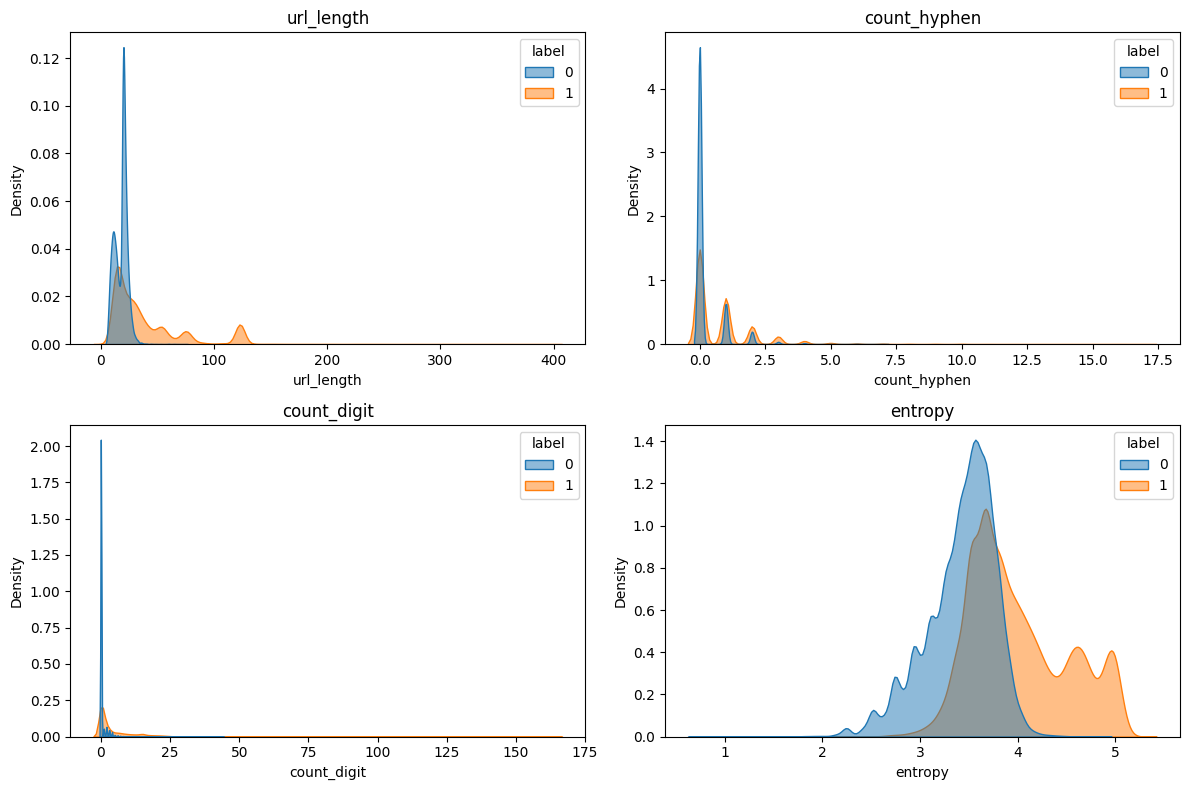

In [ ]:

MAX_URL_LEN = 400
MAX_ENTROPY  = 6.0
MAX_SUBDOMAINS = 10

before = len(dev)
dev = dev[
    (dev['url_length'] <= MAX_URL_LEN) &
    (dev['entropy'] <= MAX_ENTROPY) &
    (dev['subdomain_count'] <= MAX_SUBDOMAINS)
].copy()
after = len(dev)

print(f"Outliers removed: {before - after} | Remaining: {after}")

# Quick distribution check (light)
cols = ['url_length','count_hyphen','count_digit','entropy']
plt.figure(figsize=(12,8))
for i, c in enumerate(cols, 1):
    plt.subplot(2,2,i)
    sns.kdeplot(data=dev, x=c, hue='label', fill=True, common_norm=False, alpha=0.5)
    plt.title(c)
plt.tight_layout()
plt.show()


In [ ]:

feature_cols = [
    'url_length','domain_length','path_length','count_dot','count_hyphen',
    'count_slash','count_digit','count_alpha','count_special','has_at','has_ip',
    'subdomain_count','tld_length','entropy','has_login','has_secure',
    'has_verify','has_account','has_pay','has_update'
]

X = dev[feature_cols].values
y = dev['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Shapes:")
print("X_train_scaled:", X_train_scaled.shape)
print("X_test_scaled :", X_test_scaled.shape)
print("y_train:", y_train.shape, " | y_test:", y_test.shape)


Shapes:
X_train_scaled: (49444, 20)
X_test_scaled : (21191, 20)
y_train: (49444,)  | y_test: (21191,)


1D CNN + selected_features -> XGBoost

In [ ]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# 1) Build char-level tokenizer on ALL urls
urls_all = dev['url'].astype(str).tolist()
labels_all = dev['label'].values

tokenizer = Tokenizer(char_level=True, lower=True, filters='')
tokenizer.fit_on_texts(urls_all)

# 2) Convert to sequences and pad
max_len = 200
seq_all = tokenizer.texts_to_sequences(urls_all)
pad_all = pad_sequences(seq_all, maxlen=max_len, padding='post', truncating='post')

# 3) Create aligned train/test indices (to slice both text + tabular later)
train_idx, test_idx = train_test_split(
    np.arange(len(dev)), test_size=0.30, stratify=labels_all, random_state=42
)

X_seq_train = pad_all[train_idx]
X_seq_test  = pad_all[test_idx]
y_train = labels_all[train_idx]
y_test  = labels_all[test_idx]

print("Tokenizer vocab size:", len(tokenizer.word_index))
print("X_seq_train:", X_seq_train.shape, "| X_seq_test:", X_seq_test.shape)


Tokenizer vocab size: 56
X_seq_train: (49444, 200) | X_seq_test: (21191, 200)


In [ ]:

from sklearn.preprocessing import StandardScaler

tab_cols = [
    'url_length','domain_length','path_length','count_dot','count_hyphen',
    'count_slash','count_digit','count_alpha','count_special','has_at','has_ip',
    'subdomain_count','tld_length','entropy','has_login','has_secure',
    'has_verify','has_account','has_pay','has_update'
]

X_tab_all = dev[tab_cols].values
X_tab_train = X_tab_all[train_idx]
X_tab_test  = X_tab_all[test_idx]

scaler_tab = StandardScaler()
X_tab_train_sc = scaler_tab.fit_transform(X_tab_train)
X_tab_test_sc  = scaler_tab.transform(X_tab_test)

print("X_tab_train_sc:", X_tab_train_sc.shape, "| X_tab_test_sc:", X_tab_test_sc.shape)


X_tab_train_sc: (49444, 20) | X_tab_test_sc: (21191, 20)


In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model

vocab_size = len(tokenizer.word_index) + 1

inp = Input(shape=(max_len,))
x = Embedding(input_dim=vocab_size, output_dim=64)(inp)
x = Conv1D(64, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(1, activation='sigmoid')(x)

cnn = Model(inputs=inp, outputs=out)
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.summary()

history = cnn.fit(
    X_seq_train, y_train,
    validation_data=(X_seq_test, y_test),
    epochs=4, batch_size=512, verbose=1
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 200, 64)        │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 196, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,417 (111.00 KB)

 Trainable params: 28,417 (111.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.8562 - loss: 0.4118 - val_accuracy: 0.9712 - val_loss: 0.0966
Epoch 2/4
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9717 - loss: 0.0936 - val_accuracy: 0.9778 - val_loss: 0.0764
Epoch 3/4
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9789 - loss: 0.0757 - val_accuracy: 0.9797 - val_loss: 0.0729
Epoch 4/4
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9829 - loss: 0.0649 - val_accuracy: 0.9825 - val_loss: 0.0643


In [ ]:

from tensorflow.keras.models import Model
import numpy as np

# Feature extractor: output of the Dense(64, relu) layer (just before Dropout)
feature_extractor = Model(inputs=cnn.input, outputs=cnn.layers[-2].output)

emb_train = feature_extractor.predict(X_seq_train, batch_size=1024, verbose=1)
emb_test  = feature_extractor.predict(X_seq_test,  batch_size=1024, verbose=1)

print("CNN embedding shapes:", emb_train.shape, emb_test.shape)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
CNN embedding shapes: (49444, 64) (21191, 64)


In [ ]:

import numpy as np

X_fused_train = np.hstack([emb_train, X_tab_train_sc])  # shape: (n_train, 64 + 20)
X_fused_test  = np.hstack([emb_test,  X_tab_test_sc])   # shape: (n_test,  64 + 20)

print("Fused feature shapes:", X_fused_train.shape, X_fused_test.shape)


Fused feature shapes: (49444, 84) (21191, 84)


Hybrid Deep + Classical (CNN embeddings + Tabular → XGBoost)
Accuracy : 0.9851
Precision: 0.9950
Recall   : 0.9751
F1 Score : 0.9849


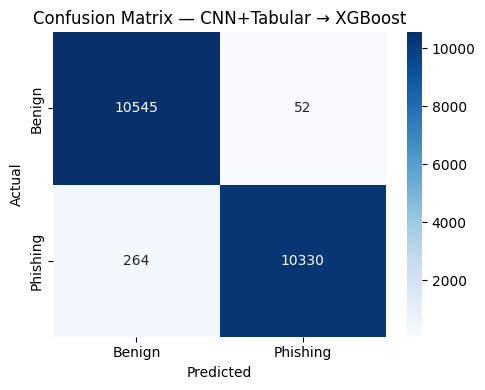

In [ ]:

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

meta = XGBClassifier(
    n_estimators=250,
    learning_rate=0.08,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

meta.fit(X_fused_train, y_train)
y_pred = meta.predict(X_fused_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Hybrid Deep + Classical (CNN embeddings + Tabular → XGBoost)")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign','Phishing'], yticklabels=['Benign','Phishing'])
plt.title("Confusion Matrix — CNN+Tabular → XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


CNN only

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model

vocab_size = len(tokenizer.word_index) + 1
max_len = X_seq_train.shape[1]

inp = Input(shape=(max_len,))
x = Embedding(input_dim=vocab_size, output_dim=64)(inp)
x = Conv1D(64, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(1, activation='sigmoid')(x)

cnn_only = Model(inputs=inp, outputs=out)
cnn_only.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_only.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 200, 64)        │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 196, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,417 (111.00 KB)

 Trainable params: 28,417 (111.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_cnn = cnn_only.fit(
    X_seq_train, y_train,
    validation_data=(X_seq_test, y_test),
    epochs=5, batch_size=512, verbose=1
)


Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8400 - loss: 0.4353 - val_accuracy: 0.9713 - val_loss: 0.0958
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9709 - loss: 0.0968 - val_accuracy: 0.9781 - val_loss: 0.0762
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9780 - loss: 0.0778 - val_accuracy: 0.9810 - val_loss: 0.0673
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9824 - loss: 0.0660 - val_accuracy: 0.9832 - val_loss: 0.0626
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9842 - loss: 0.0613 - val_accuracy: 0.9835 - val_loss: 0.0594


In [ ]:


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_cnn = (cnn_only.predict(X_seq_test) > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred_cnn)
prec = precision_score(y_test, y_pred_cnn)
rec = recall_score(y_test, y_pred_cnn)
f1 = f1_score(y_test, y_pred_cnn)

print("\n CNN-Only Model Performance")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")


663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

 CNN-Only Model Performance
Accuracy : 0.9835
Precision: 0.9946
Recall   : 0.9723
F1 Score : 0.9833


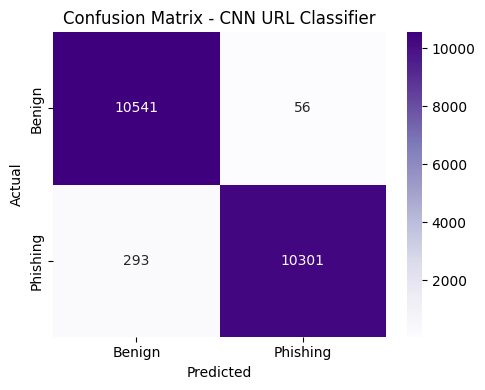

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Benign','Phishing'], yticklabels=['Benign','Phishing'])
plt.title("Confusion Matrix - CNN URL Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Tabular LightGBM

In [ ]:


from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define tabular feature set
tab_features = [
    'url_length','domain_length','path_length','count_dot','count_hyphen',
    'count_slash','count_digit','count_alpha','count_special','has_at','has_ip',
    'subdomain_count','tld_length','entropy','has_login','has_secure',
    'has_verify','has_account','has_pay','has_update'
]

# Train and test splits (already scaled)
X_train_tab = X_tab_train_sc
X_test_tab  = X_tab_test_sc

# Initialize LightGBM
lgbm_tab = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.08,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary',
    random_state=42,
    n_jobs=-1
)

# Train model
lgbm_tab.fit(X_train_tab, y_train)

# Predict
y_pred_tab = lgbm_tab.predict(X_test_tab)

# Evaluate performance
acc = accuracy_score(y_test, y_pred_tab)
prec = precision_score(y_test, y_pred_tab)
rec = recall_score(y_test, y_pred_tab)
f1 = f1_score(y_test, y_pred_tab)

print("Tabular-Only Model (LightGBM) Performance")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")


[LightGBM] [Info] Number of positive: 24719, number of negative: 24725
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 49444, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499939 -> initscore=-0.000243
[LightGBM] [Info] Start training from score -0.000243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Tabular-Only Model (LightGBM) Performance
Accuracy : 0.9766
Precision: 0.9938
Recall   : 0.9591
F1 Score : 0.9762


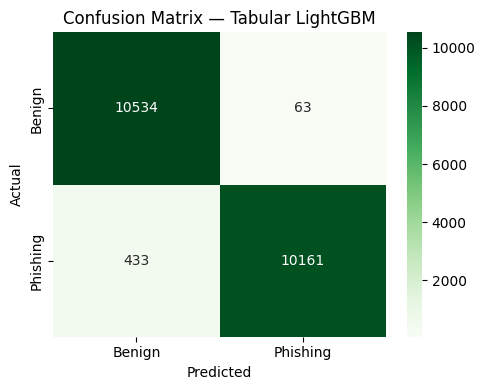

/tmp/ipython-input-2568096334.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices[:10]], y=top_features, palette='crest')


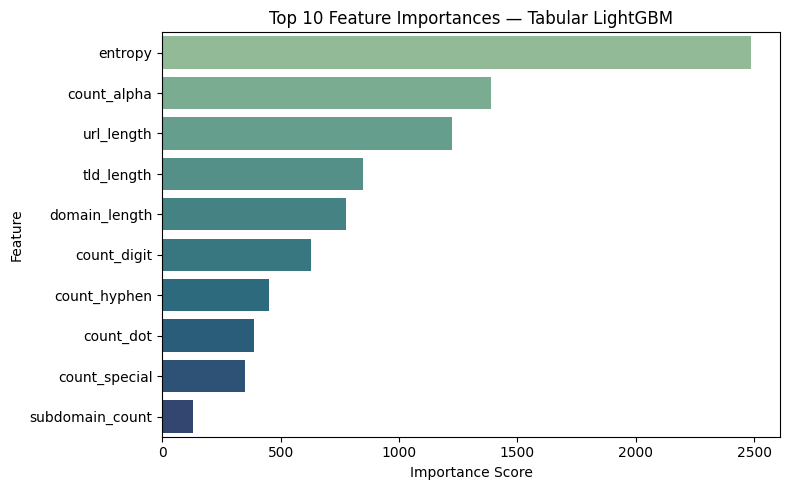

In [ ]:

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tab)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Benign','Phishing'], yticklabels=['Benign','Phishing'])
plt.title("Confusion Matrix — Tabular LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Feature Importance
importances = lgbm_tab.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = [tab_features[i] for i in indices[:10]]

plt.figure(figsize=(8,5))
sns.barplot(x=importances[indices[:10]], y=top_features, palette='crest')
plt.title("Top 10 Feature Importances — Tabular LightGBM")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
